# Fashion Synthesis Evaluation - AMD GPU Version

## Overview
This notebook evaluates the LoRA-trained model by calculating quantitative metrics and generating qualitative comparisons.

## Prerequisites
1. ✅ Training completed (controllable-fashion-image-synthesis-v1.ipynb)
2. ✅ Generated images exist at: `./working/eval_data/`
3. ✅ All dependencies installed (requirements.txt)

## Metrics Calculated
1. **FID (Fréchet Inception Distance)** - Image quality
2. **KID (Kernel Inception Distance)** - Image diversity
3. **LPIPS (Learned Perceptual Image Patch Similarity)** - Perceptual similarity
4. **CLIP Score** - Text-image alignment

---


In [6]:
# CELL 1: Setup and Verify Environment
import os
import torch

print("🔧 Environment Check")
print("=" * 50)
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    print(f"GPU 0: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ No GPU detected, using CPU (slower)")
    device = torch.device("cpu")

print("=" * 50)

# Verify required packages
try:
    import lpips
    from cleanfid import fid
    from transformers import CLIPProcessor, CLIPModel
    print("✅ All evaluation dependencies available")
except ImportError as e:
    print(f"❌ Missing dependency: {e}")
    print("Run: pip install -r requirements.txt")

🔧 Environment Check
PyTorch Version: 2.5.1+rocm6.2
GPU Available: True
GPU Count: 8
GPU 0: AMD Instinct MI250X/MI250
✅ All evaluation dependencies available


In [7]:
# CELL 2: Locate and Verify Data
import os
import shutil

# --- Data Paths ---
WORKING_DIR = "./working"
EVAL_DATA_PATH = os.path.join(WORKING_DIR, "eval_data")
GT_DIR = os.path.join(EVAL_DATA_PATH, "gt")
BASE_DIR = os.path.join(EVAL_DATA_PATH, "baseline")
LORA_DIR = os.path.join(EVAL_DATA_PATH, "lora")
CONFIG_PATH = os.path.join(EVAL_DATA_PATH, "eval_configs.json")

OUTPUT_DIR = os.path.join(WORKING_DIR, "fashion_lora_output")
TRAINING_LOSS_PLOT = os.path.join(WORKING_DIR, "training_loss.png")

# Verify all required directories and files exist
print("📂 Checking Data Directories...")
print("=" * 50)

missing = []
if not os.path.exists(GT_DIR):
    missing.append(f"Ground Truth: {GT_DIR}")
if not os.path.exists(BASE_DIR):
    missing.append(f"Baseline: {BASE_DIR}")
if not os.path.exists(LORA_DIR):
    missing.append(f"LoRA: {LORA_DIR}")
if not os.path.exists(CONFIG_PATH):
    missing.append(f"Config: {CONFIG_PATH}")

if missing:
    print("❌ Missing required files/directories:")
    for m in missing:
        print(f"   - {m}")
    print("\n⚠️ Please run the main training notebook first to generate evaluation data!")
    print("   Notebook: controllable-fashion-image-synthesis-v1.ipynb")
    raise FileNotFoundError("Required evaluation data not found")

# Count files
gt_count = len([f for f in os.listdir(GT_DIR) if f.endswith('.png')])
base_count = len([f for f in os.listdir(BASE_DIR) if f.endswith('.png')])
lora_count = len([f for f in os.listdir(LORA_DIR) if f.endswith('.png')])

print(f"✅ Found Data at: {EVAL_DATA_PATH}")
print(f"   - GT Images: {gt_count}")
print(f"   - Baseline Images: {base_count}")
print(f"   - LoRA Images: {lora_count}")

if gt_count != base_count or gt_count != lora_count:
    print(f"\n⚠️ Warning: Image counts don't match!")
    print(f"   Expected all to have {gt_count} images")
    
print("=" * 50)

📂 Checking Data Directories...
✅ Found Data at: ./working/eval_data
   - GT Images: 10000
   - Baseline Images: 10000
   - LoRA Images: 10000


In [8]:
# CELL 3: Calculate Metrics (AMD GPU Compatible)
import torch
import numpy as np
import os
import json
from cleanfid import fid
import lpips
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm.auto import tqdm

# Device setup (AMD GPU compatible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🎮 Using device: {device}")

# Load Configs
with open(CONFIG_PATH, 'r') as f:
    eval_configs = json.load(f)

metrics = {"baseline": {}, "lora": {}}

print("\n" + "="*60)
print("📊 CALCULATING METRICS")
print("="*60)

# --- 1. FID & KID ---
print("\n📏 Calculating FID and KID...")
print("   (This may take a few minutes depending on image count)")
try:
    # Baseline
    print("   → Baseline FID...")
    metrics["baseline"]["fid"] = fid.compute_fid(GT_DIR, BASE_DIR, mode="clean", num_workers=0)
    print("   → Baseline KID...")
    metrics["baseline"]["kid"] = fid.compute_kid(GT_DIR, BASE_DIR, mode="clean", num_workers=0)
    
    # LoRA
    print("   → LoRA FID...")
    metrics["lora"]["fid"] = fid.compute_fid(GT_DIR, LORA_DIR, mode="clean", num_workers=0)
    print("   → LoRA KID...")
    metrics["lora"]["kid"] = fid.compute_kid(GT_DIR, LORA_DIR, mode="clean", num_workers=0)
    print("   ✅ FID/KID calculation complete")
except Exception as e:
    print(f"   ⚠️ FID/KID calculation failed: {e}")
    metrics["baseline"]["fid"] = None
    metrics["baseline"]["kid"] = None
    metrics["lora"]["fid"] = None
    metrics["lora"]["kid"] = None

# --- 2. LPIPS ---
print("\n📏 Calculating LPIPS (perceptual similarity)...")
try:
    loss_fn_alex = lpips.LPIPS(net='alex').to(device)

    def calc_lpips(dir1, dir2):
        scores = []
        files = sorted([f for f in os.listdir(dir1) if f.endswith('.png')])
        for f in tqdm(files, desc="   LPIPS", leave=False):
            p1 = os.path.join(dir1, f)
            p2 = os.path.join(dir2, f)
            if os.path.exists(p2):
                img1 = lpips.im2tensor(lpips.load_image(p1)).to(device)
                img2 = lpips.im2tensor(lpips.load_image(p2)).to(device)
                with torch.no_grad():
                    scores.append(loss_fn_alex(img1, img2).item())
        return np.mean(scores) if scores else None

    metrics["baseline"]["lpips"] = calc_lpips(GT_DIR, BASE_DIR)
    metrics["lora"]["lpips"] = calc_lpips(GT_DIR, LORA_DIR)
    print("   ✅ LPIPS calculation complete")
    
    # Clear memory
    del loss_fn_alex
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
except Exception as e:
    print(f"   ⚠️ LPIPS calculation failed: {e}")
    metrics["baseline"]["lpips"] = None
    metrics["lora"]["lpips"] = None

# --- 3. CLIP Score ---
print("\n📏 Calculating CLIP Score (text-image alignment)...")
try:
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def calc_clip(image_dir, configs):
        scores = []
        for item in tqdm(configs, desc="   CLIP", leave=False):
            idx = item['idx']
            prompt = item['prompt']
            img_path = os.path.join(image_dir, f"{idx:06d}.png")
            if os.path.exists(img_path):
                try:
                    image = Image.open(img_path).convert('RGB')
                    # Fixed: Added truncation and max_length
                    inputs = clip_processor(
                        text=[prompt], 
                        images=image, 
                        return_tensors="pt", 
                        padding=True, 
                        truncation=True, 
                        max_length=77
                    ).to(device)
                    
                    with torch.no_grad():
                        outputs = clip_model(**inputs)
                        logits_per_image = outputs.logits_per_image 
                        scores.append(logits_per_image.item() / 100.0)
                except Exception as e:
                    print(f"      Warning: Failed to process {img_path}: {e}")
                    continue
        return np.mean(scores) if scores else None

    metrics["baseline"]["clip"] = calc_clip(BASE_DIR, eval_configs)
    metrics["lora"]["clip"] = calc_clip(LORA_DIR, eval_configs)
    print("   ✅ CLIP Score calculation complete")
    
    # Clear memory
    del clip_model, clip_processor
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
except Exception as e:
    print(f"   ⚠️ CLIP Score calculation failed: {e}")
    metrics["baseline"]["clip"] = None
    metrics["lora"]["clip"] = None

# --- Save Results ---
output_path = os.path.join(WORKING_DIR, "final_metrics.json")
with open(output_path, "w") as f:
    json.dump(metrics, f, indent=4)

print("\n" + "="*60)
print("📊 EVALUATION RESULTS")
print("="*60)
print(json.dumps(metrics, indent=2))
print("="*60)
print(f"\n✅ Results saved to: {output_path}")

# Print summary table
print("\n📈 Summary Table:")
print("-" * 60)
print(f"{'Metric':<15} {'Baseline':<20} {'LoRA (Ours)':<20}")
print("-" * 60)
for metric_name in ['fid', 'kid', 'lpips', 'clip']:
    base_val = metrics['baseline'].get(metric_name)
    lora_val = metrics['lora'].get(metric_name)
    base_str = f"{base_val:.4f}" if base_val is not None else "N/A"
    lora_str = f"{lora_val:.4f}" if lora_val is not None else "N/A"
    print(f"{metric_name.upper():<15} {base_str:<20} {lora_str:<20}")
print("-" * 60)

print("\n💡 Interpretation:")
print("   - FID/KID: Lower is better (image quality)")
print("   - LPIPS: Lower is better (closer to ground truth)")
print("   - CLIP: Higher is better (text-image alignment)")

🎮 Using device: cuda

📊 CALCULATING METRICS

📏 Calculating FID and KID...
   (This may take a few minutes depending on image count)
   → Baseline FID...
compute FID between two folders
Found 10000 images in the folder ./working/eval_data/gt


FID gt :   5%|▌         | 16/313 [00:05<01:08,  4.35it/s]

FID gt : 100%|██████████| 313/313 [01:36<00:00,  3.25it/s]


Found 10000 images in the folder ./working/eval_data/baseline


FID baseline : 100%|██████████| 313/313 [01:34<00:00,  3.32it/s]


   → Baseline KID...
compute KID between two folders
Found 10000 images in the folder ./working/eval_data/gt


KID gt : 100%|██████████| 313/313 [01:37<00:00,  3.22it/s]


Found 10000 images in the folder ./working/eval_data/baseline


KID baseline : 100%|██████████| 313/313 [01:44<00:00,  2.99it/s]


   → LoRA FID...
compute FID between two folders
Found 10000 images in the folder ./working/eval_data/gt


FID gt : 100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Found 10000 images in the folder ./working/eval_data/lora


FID lora : 100%|██████████| 313/313 [01:30<00:00,  3.45it/s]


   → LoRA KID...
compute KID between two folders
Found 10000 images in the folder ./working/eval_data/gt


KID gt : 100%|██████████| 313/313 [01:30<00:00,  3.45it/s]


Found 10000 images in the folder ./working/eval_data/lora


KID lora : 100%|██████████| 313/313 [01:38<00:00,  3.18it/s]


   ✅ FID/KID calculation complete

📏 Calculating LPIPS (perceptual similarity)...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/husnain/DLP/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/husnain/DLP/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/husnain/DLP/.venv/lib/python3.10/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/

Loading model from: /home/husnain/DLP/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth


/home/husnain/DLP/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


   ✅ LPIPS calculation complete

📏 Calculating CLIP Score (text-image alignment)...


   ✅ CLIP Score calculation complete

📊 EVALUATION RESULTS
{
  "baseline": {
    "fid": 75.18956689081321,
    "kid": 0.06451492628128132,
    "lpips": 0.6177227392688394,
    "clip": 0.2835409451990128
  },
  "lora": {
    "fid": 17.676111960872902,
    "kid": 0.010023632207207216,
    "lpips": 0.2899785393726081,
    "clip": 0.30364964344120027
  }
}

✅ Results saved to: ./working/final_metrics.json

📈 Summary Table:
------------------------------------------------------------
Metric          Baseline             LoRA (Ours)         
------------------------------------------------------------
FID             75.1896              17.6761             
KID             0.0645               0.0100              
LPIPS           0.6177               0.2900              
CLIP            0.2835               0.3036              
------------------------------------------------------------

💡 Interpretation:
   - FID/KID: Lower is better (image quality)
   - LPIPS: Lower is better (closer to 

🎨 Creating Qualitative Comparison Grid...
   ✅ Saved qualitative comparison to: ./working/qualitative_comparison.png


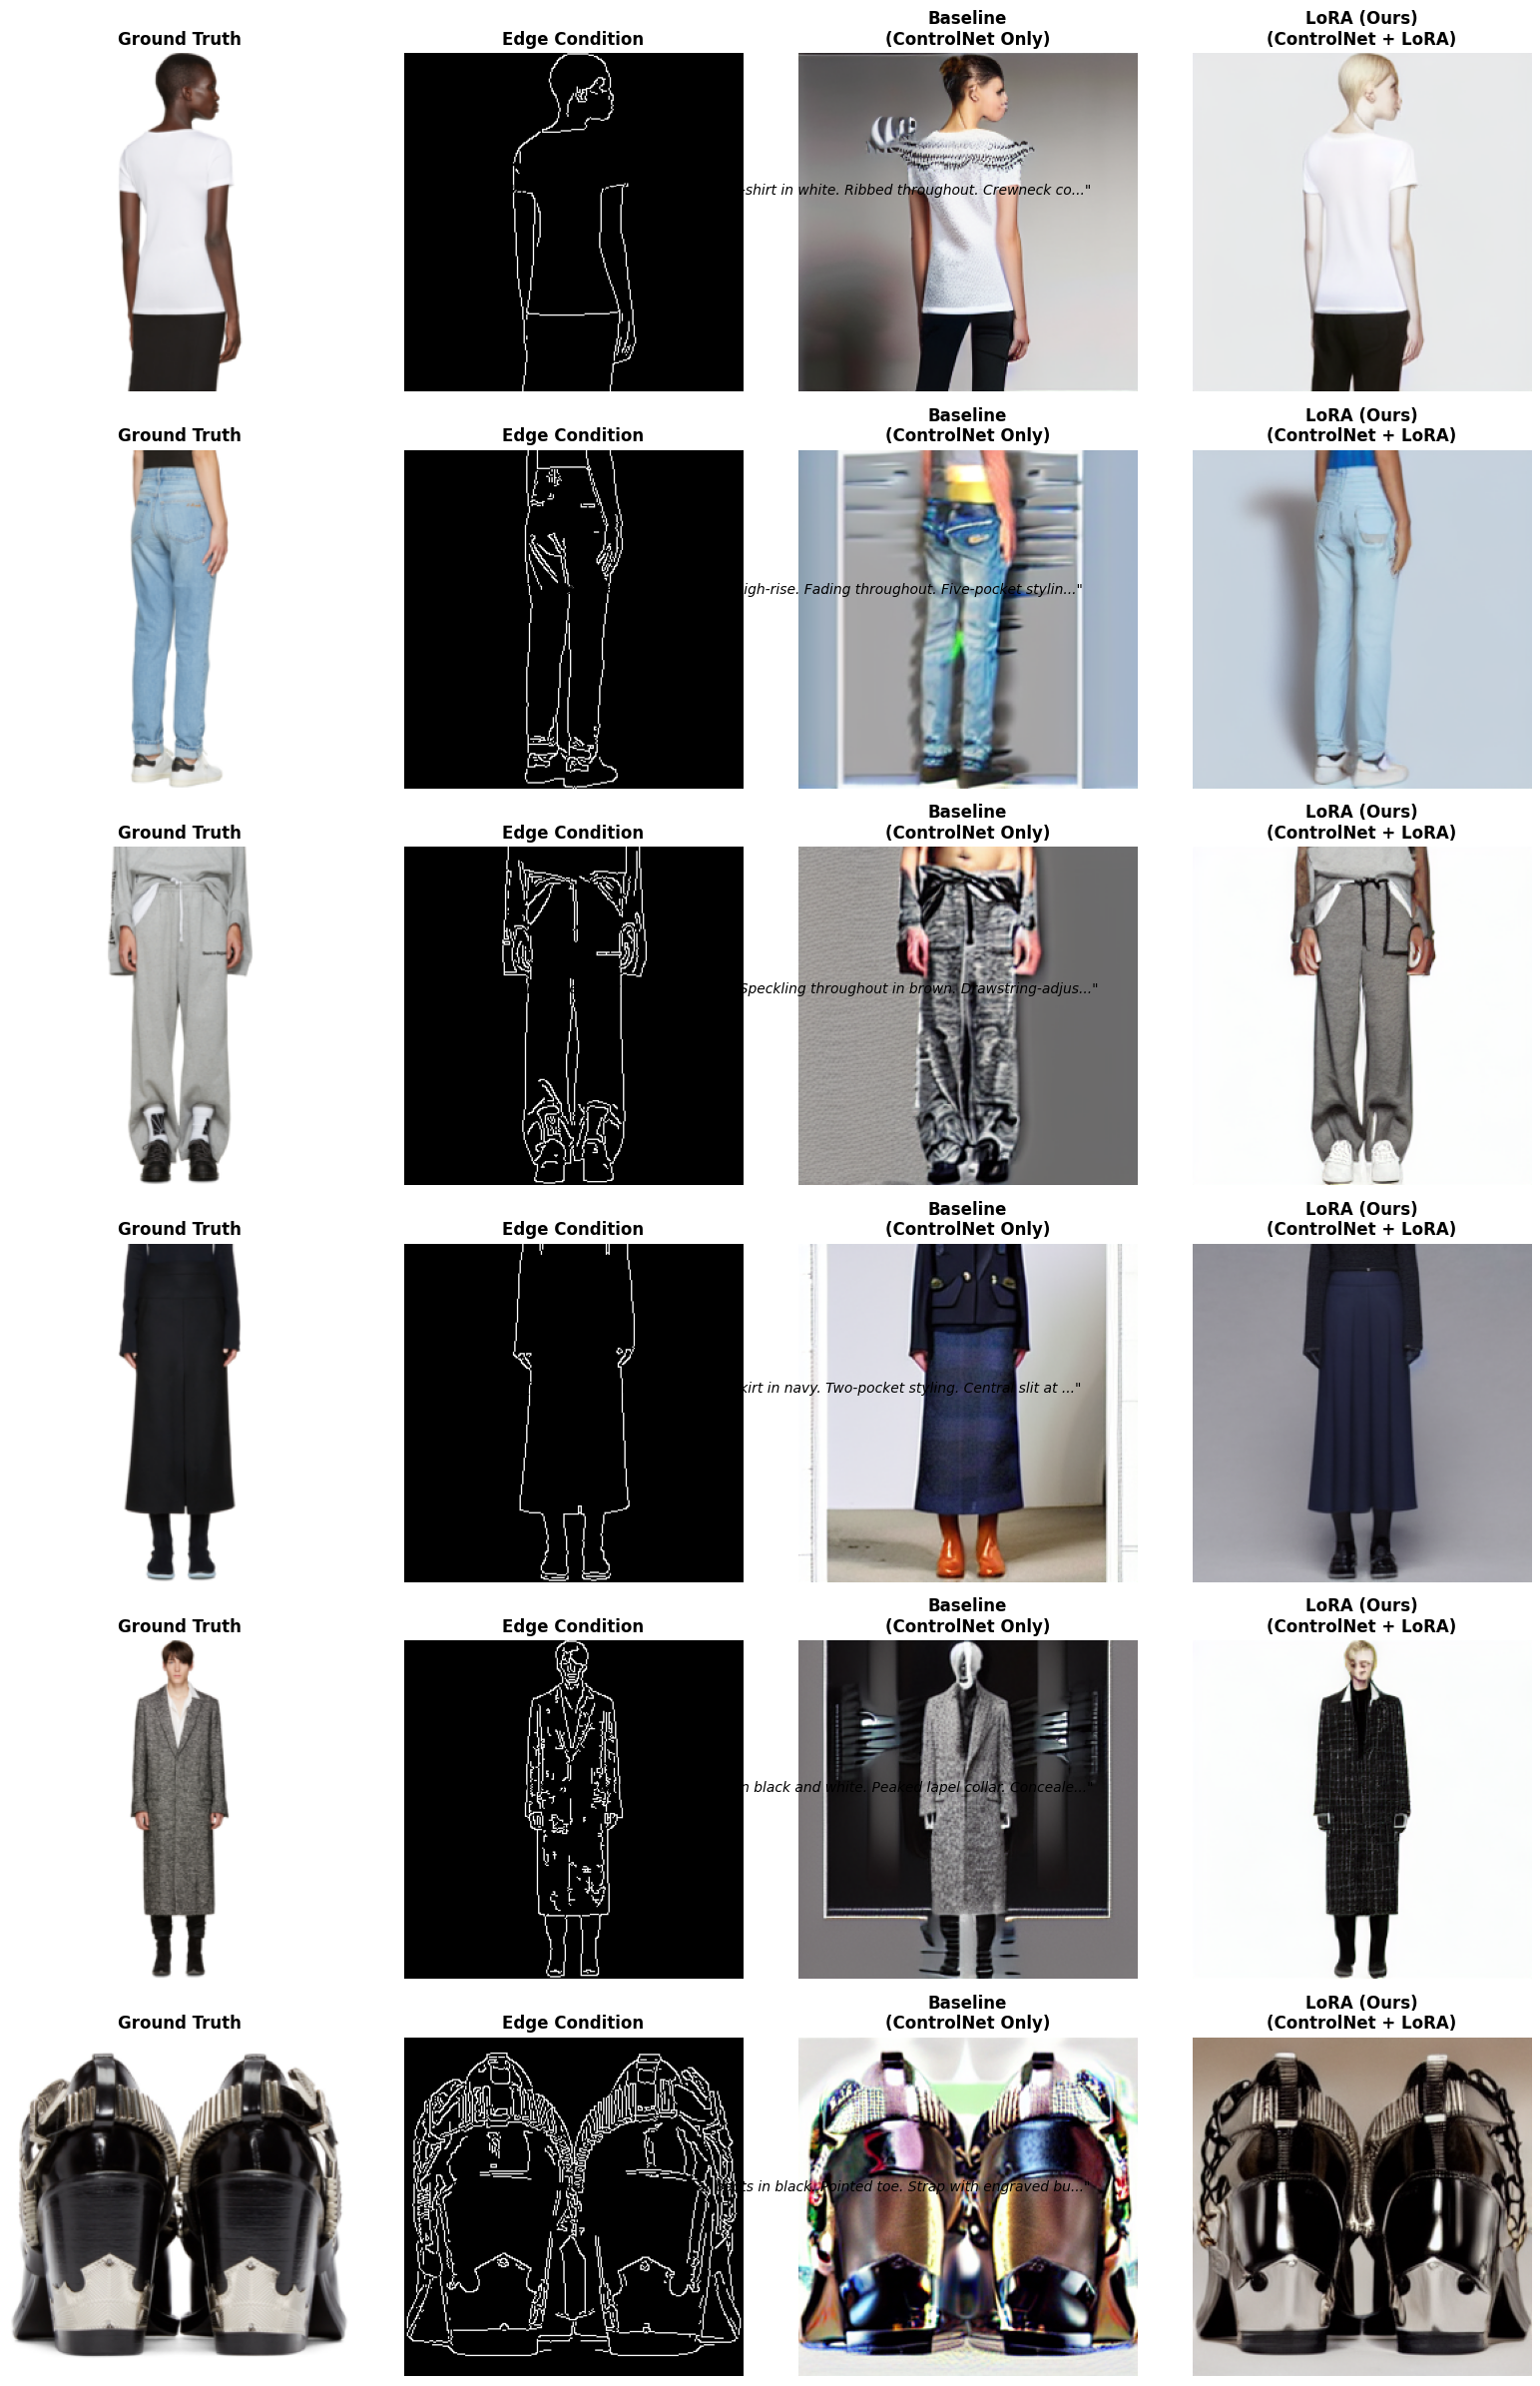


💡 Tip: You can generate more samples by calling show_grid(n=10) for example


In [9]:
# CELL 4: Qualitative Visualization
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
from PIL import Image
import os
import json

print("🎨 Creating Qualitative Comparison Grid...")

def show_grid(n=6, save_path=None):
    """
    Create a grid comparing GT, Edge, Baseline, and LoRA outputs
    
    Args:
        n: Number of samples to show
        save_path: Path to save the figure (if None, auto-generated)
    """
    if save_path is None:
        save_path = os.path.join(WORKING_DIR, "qualitative_comparison.png")
    
    with open(CONFIG_PATH, 'r') as f:
        configs = json.load(f)
    
    # Random sample or use first n if fewer configs
    n_samples = min(n, len(configs))
    samples = random.sample(configs, n_samples)
    
    fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
    
    # Handle single row case
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, item in enumerate(samples):
        idx = item['idx']
        prompt = item['prompt']
        
        # Load images
        gt_path = os.path.join(GT_DIR, f"{idx:06d}.png")
        base_path = os.path.join(BASE_DIR, f"{idx:06d}.png")
        lora_path = os.path.join(LORA_DIR, f"{idx:06d}.png")
        
        if not all([os.path.exists(p) for p in [gt_path, base_path, lora_path]]):
            print(f"   ⚠️ Skipping sample {idx} - missing images")
            continue
        
        gt = Image.open(gt_path).convert('RGB')
        base = Image.open(base_path).convert('RGB')
        lora = Image.open(lora_path).convert('RGB')
        
        # Generate edge map
        edge = cv2.Canny(np.array(gt), 100, 200)
        edge = Image.fromarray(np.stack([edge]*3, axis=-1))
        
        # Plot
        axes[i,0].imshow(gt)
        axes[i,0].set_title("Ground Truth", fontsize=12, fontweight='bold')
        axes[i,0].axis('off')
        
        axes[i,1].imshow(edge)
        axes[i,1].set_title("Edge Condition", fontsize=12, fontweight='bold')
        axes[i,1].axis('off')
        
        axes[i,2].imshow(base)
        axes[i,2].set_title("Baseline\n(ControlNet Only)", fontsize=12, fontweight='bold')
        axes[i,2].axis('off')
        
        axes[i,3].imshow(lora)
        axes[i,3].set_title("LoRA (Ours)\n(ControlNet + LoRA)", fontsize=12, fontweight='bold')
        axes[i,3].axis('off')
        
        # Add prompt as text below the row
        fig.text(0.5, 1.0 - (i+0.5)/n_samples, f'Prompt: "{prompt[:80]}..."', 
                ha='center', fontsize=10, style='italic', wrap=True)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"   ✅ Saved qualitative comparison to: {save_path}")
    plt.show()

# Generate grid with 6 random samples
show_grid(n=6)

print("\n💡 Tip: You can generate more samples by calling show_grid(n=10) for example")

In [10]:
# CELL 5: Package Results
import zipfile
import os
from datetime import datetime

output_zip = os.path.join(WORKING_DIR, "evaluation_results.zip")
print(f"📦 Packaging results to: {output_zip}")
print("=" * 60)

files_to_include = []

# Metrics
metrics_path = os.path.join(WORKING_DIR, "final_metrics.json")
if os.path.exists(metrics_path):
    files_to_include.append(("final_metrics.json", metrics_path))
    print(f"   ✅ Including: final_metrics.json")

# Qualitative comparison
qual_path = os.path.join(WORKING_DIR, "qualitative_comparison.png")
if os.path.exists(qual_path):
    files_to_include.append(("qualitative_comparison.png", qual_path))
    print(f"   ✅ Including: qualitative_comparison.png")

# Training loss plot
if os.path.exists(TRAINING_LOSS_PLOT):
    files_to_include.append(("training_loss.png", TRAINING_LOSS_PLOT))
    print(f"   ✅ Including: training_loss.png")
else:
    print(f"   ⚠️ Training loss plot not found at: {TRAINING_LOSS_PLOT}")

# LoRA weights
weights_path = os.path.join(OUTPUT_DIR, "pytorch_lora_weights.safetensors")
if os.path.exists(weights_path):
    files_to_include.append(("weights/pytorch_lora_weights.safetensors", weights_path))
    print(f"   ✅ Including: LoRA weights")
else:
    print(f"   ⚠️ LoRA weights not found at: {weights_path}")

# Config file
if os.path.exists(CONFIG_PATH):
    files_to_include.append(("eval_configs.json", CONFIG_PATH))
    print(f"   ✅ Including: eval_configs.json")

# Create ZIP
if files_to_include:
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zf:
        for arc_name, file_path in files_to_include:
            zf.write(file_path, arc_name)
            
    # Get zip size
    zip_size = os.path.getsize(output_zip) / (1024**2)  # MB
    print("=" * 60)
    print(f"✅ Created: {output_zip}")
    print(f"   Size: {zip_size:.2f} MB")
    print(f"   Files: {len(files_to_include)}")
else:
    print("=" * 60)
    print("⚠️ No files to package!")
    
print("\n📊 Evaluation Complete!")
print("=" * 60)
print("\nResults Summary:")
print(f"  - Metrics: {metrics_path}")
print(f"  - Visualization: {qual_path}")
print(f"  - Package: {output_zip}")
print("\nAll files are in: {WORKING_DIR}")

📦 Packaging results to: ./working/evaluation_results.zip
   ✅ Including: final_metrics.json
   ✅ Including: qualitative_comparison.png
   ⚠️ Training loss plot not found at: ./working/training_loss.png
   ✅ Including: LoRA weights
   ✅ Including: eval_configs.json
✅ Created: ./working/evaluation_results.zip
   Size: 6.72 MB
   Files: 4

📊 Evaluation Complete!

Results Summary:
  - Metrics: ./working/final_metrics.json
  - Visualization: ./working/qualitative_comparison.png
  - Package: ./working/evaluation_results.zip

All files are in: {WORKING_DIR}
